In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned transactional data
df = pd.read_excel('../data/online_retail.xlsx')


In [2]:
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove returns/cancellations (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Keep only positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column if not already present
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [3]:
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [4]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [5]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [10]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)


In [12]:
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champion'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Big Spender'
    elif row['R_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


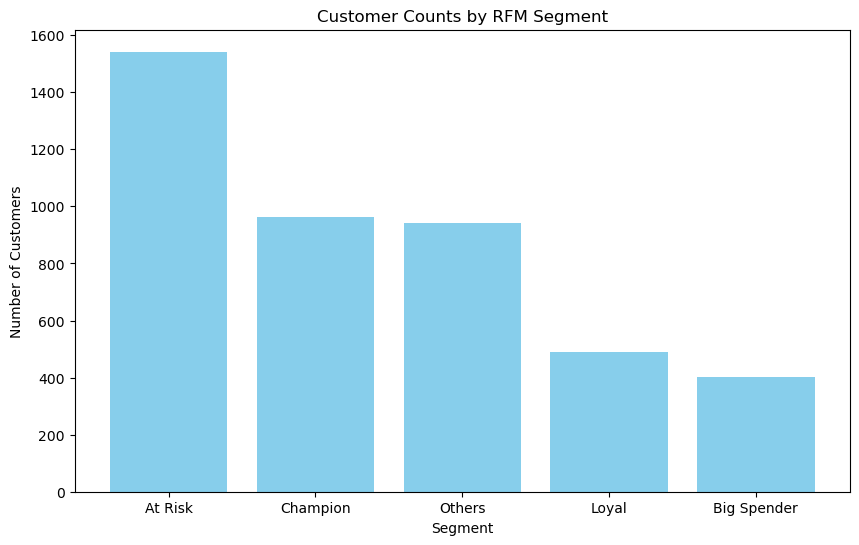

In [13]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(segment_counts.index, segment_counts.values, color='skyblue')
plt.title('Customer Counts by RFM Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()


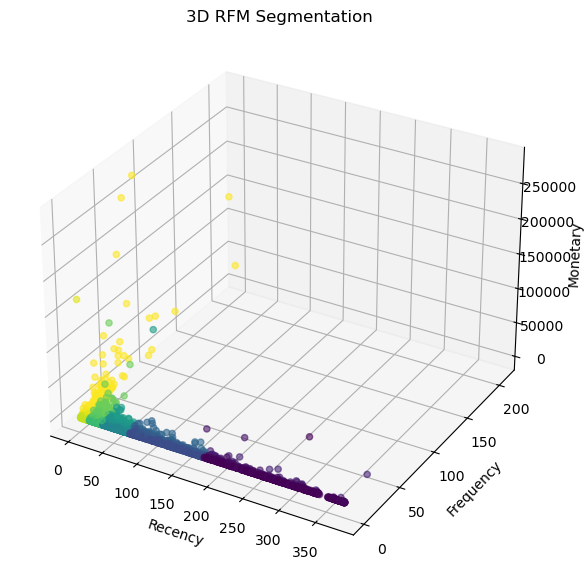

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=rfm['RFM_Score'].astype(int), cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Segmentation')
plt.show()


 Segment | Recency (Median) | Frequency (Median) | Monetary (Median) | Key Characteristics | Recommended Action |
| :-- | :-- | :-- | :-- | :-- | :-- |
| Champion | Lowest | Highest | Highest | Recent, frequent, high spenders | Retain with VIP rewards, exclusives |
| Big Spender | Moderate | High | Very High | High spend, less recent/frequent | Upsell, premium offers |
| Loyal | Very Low | High | Moderate | Frequent, recent, moderate spend | Loyalty incentives, cross-sell |
| At Risk | High | Low | Low | Not recent, low frequency/spend | Win-back campaigns, re-engagement |
| Others | Moderate | Moderate | Moderate | Average on all metrics | Nurture, monitor for upgrades |


In [15]:
#Low Recency value = more recent purchase = higher R_Score = more likely to be a Champion.